In [1]:
import numpy as np
import matplotlib.pyplot as plt
import swiftest
from astroquery.jplhorizons import Horizons

In [2]:
%env HDF5_USE_FILE_LOCKING=FALSE
sim = swiftest.Simulation(param_file="param.swiftest.in")

env: HDF5_USE_FILE_LOCKING=FALSE
Reading Swiftest file param.swiftest.in

Creating Dataset from NetCDF file
Successfully converted 1001 output frames.
Swiftest simulation data stored as xarray DataSet .ds


In [3]:
sim.ds = sim.ds.swap_dims({"id" : "name"})
sim.ds['varpi'] = sim.ds['omega'] + sim.ds['capom']

In [4]:
obj = Horizons(id='1', id_type='majorbody',location='@sun',
               epochs={'start':'2021-01-28', 'stop':'3021-02-05',
                       'step':'1y'})
el = obj.elements()
t = (el['datetime_jd']-el['datetime_jd'][0]) / 365.25
varpi_obs = el['w'] + el['Omega']

In [5]:
tsim = sim.ds['time']
varpiswiftest = sim.ds.sel(name='Mercury')['varpi']

In [6]:
diff_varpi = varpiswiftest - varpi_obs

In [7]:
dvarpi_swiftest = np.diff(varpiswiftest)  * 3600 * 100 
dvarpi_obs = np.diff(varpi_obs) / np.diff(t) * 3600 * 100 

Mean precession rate for Mercury long. peri. (arcsec/100 y)
JPL Horizons      : 571.3210506300043
Swiftest-Helio GR : 570.6677380786499
Obs - Swiftest    : 0.6533125513543501


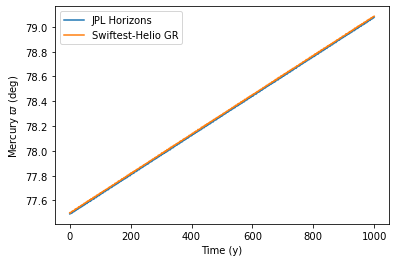

In [8]:
fig, ax = plt.subplots()

ax.plot(t, varpi_obs, label="JPL Horizons")
ax.plot(tsim, varpiswiftest, label="Swiftest-Helio GR")
ax.set_xlabel('Time (y)')
ax.set_ylabel('Mercury $\\varpi$ (deg)')
ax.legend()
print('Mean precession rate for Mercury long. peri. (arcsec/100 y)')
print(f'JPL Horizons      : {np.mean(dvarpi_obs)}')
print(f'Swiftest-Helio GR : {np.mean(dvarpi_swiftest)}')
print(f'Obs - Swiftest    : {np.mean(dvarpi_obs - dvarpi_swiftest)}')
plt.savefig(f'helio_gr_test.png', dpi=300,facecolor='white', transparent=False)

No handles with labels found to put in legend.


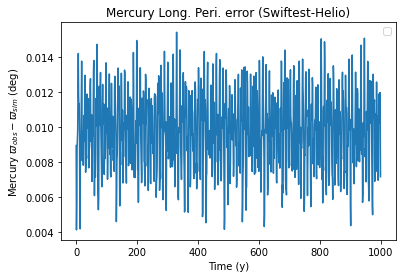

In [9]:
fig, ax = plt.subplots()

ax.plot(tsim, diff_varpi)
ax.set_xlabel('Time (y)')
ax.set_ylabel('Mercury $\\varpi_{obs} - \\varpi_{sim}$ (deg)')
ax.set_title("Mercury Long. Peri. error (Swiftest-Helio)")
ax.legend()
plt.savefig(f'helio_gr_diffvarpi.png', dpi=300,facecolor='white', transparent=False)